In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
with open('resources/data-clean-list.npy', 'rb') as infile:
    data_lemmatized = np.load(infile)
    
data_lemmatized = list(data_lemmatized)

In [3]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [4]:
# Create Corpus
texts = list(data_lemmatized)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('actually', 1), ('add', 1), ('adverse', 1), ('advice', 1), ('advise', 2), ('ago', 1), ('alone', 1), ('amazon', 1), ('ambulance', 1), ('anymore', 1), ('anyone', 1), ('anything', 1), ('anyway', 2), ('appointment', 1), ('appreciate', 1), ('ask', 1), ('aspirin', 2), ('asshole', 1), ('assume', 1), ('attempt', 1), ('awake', 1), ('away', 1), ('awhile', 1), ('back', 1), ('become', 1), ('bed', 1), ('blood', 2), ('bridge', 1), ('budget', 1), ('burden', 1), ('burn', 1), ('bury', 1), ('call', 1), ('can', 2), ('candy', 1), ('care', 1), ('casino', 1), ('cement', 1), ('certain', 1), ('channel', 1), ('come', 1), ('complain', 1), ('consider', 1), ('control', 1), ('cotton', 1), ('could', 4), ('crush', 1), ('cry', 1), ('dad', 1), ('day', 1), ('dead', 1), ('debt', 1), ('decide', 1), ('deed', 1), ('degree', 4), ('depress', 1), ('depressed', 2), ('despair', 1), ('die', 4), ('disappear', 1), ('disappoint', 1), ('distraction', 1), ('do', 11), ('doctor', 1), ('drop', 1), ('effort', 1), ('emotional', 1), ('e

In [5]:
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [6]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(18,
  [('parent', 0.06382746977453436),
   ('child', 0.03659732055331663),
   ('man', 0.02592310205859928),
   ('young', 0.0254874196710598),
   ('people', 0.023744690120901864),
   ('age', 0.022328722361398542),
   ('kid', 0.021893039973859055),
   ('reason', 0.01524888356388193),
   ('woman', 0.013179392223069382),
   ('adult', 0.01285263043241477)]),
 (19,
  [('question', 0.03106558289722748),
   ('person', 0.026945774412648924),
   ('case', 0.022157888876517092),
   ('fact', 0.017592695690903017),
   ('point', 0.0171473109898675),
   ('answer', 0.01525442601046654),
   ('action', 0.013584233381583342),
   ('simply', 0.013250194855806703),
   ('true', 0.012025386927959025),
   ('act', 0.011691348402182385)]),
 (10,
  [('work', 0.10459873760144274),
   ('job', 0.062218214607754736),
   ('pay', 0.047790802524797116),
   ('money', 0.03276224827171626),
   ('year', 0.017633503656948202),
   ('company', 0.01603045786995291),
   ('good', 0.014126840997896002),
   ('require', 0.012423604

In [7]:
# Compute Coherence Score
coherence_model_ldamallet = models.CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4326343288732244


In [8]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

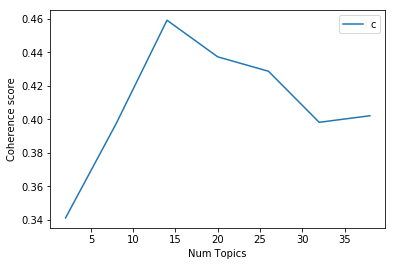

In [10]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [11]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.341
Num Topics = 8  has Coherence Value of 0.3975
Num Topics = 14  has Coherence Value of 0.4592
Num Topics = 20  has Coherence Value of 0.4373
Num Topics = 26  has Coherence Value of 0.4287
Num Topics = 32  has Coherence Value of 0.3982
Num Topics = 38  has Coherence Value of 0.4021


In [12]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.078*"people" + 0.031*"fuck" + 0.030*"give" + 0.027*"man" + 0.023*"kind" + '
  '0.022*"guy" + 0.020*"person" + 0.020*"stop" + 0.020*"wrong" + 0.019*"shit"'),
 (1,
  '0.060*"school" + 0.025*"friend" + 0.024*"teacher" + 0.023*"kid" + '
  '0.021*"student" + 0.018*"make" + 0.015*"class" + 0.012*"bully" + '
  '0.012*"girl" + 0.012*"lot"'),
 (2,
  '0.098*"feel" + 0.049*"friend" + 0.046*"find" + 0.036*"thing" + 0.031*"life" '
  '+ 0.028*"talk" + 0.019*"change" + 0.017*"understand" + 0.015*"happy" + '
  '0.014*"people"'),
 (3,
  '0.090*"good" + 0.039*"parent" + 0.038*"bad" + 0.037*"thing" + '
  '0.037*"problem" + 0.030*"hope" + 0.028*"situation" + 0.025*"care" + '
  '0.024*"family" + 0.020*"sound"'),
 (4,
  '0.022*"high" + 0.019*"year" + 0.019*"young" + 0.017*"government" + '
  '0.017*"age" + 0.016*"pay" + 0.013*"low" + 0.013*"make" + 0.013*"issue" + '
  '0.011*"singaporean"'),
 (5,
  '0.022*"law" + 0.017*"society" + 0.017*"people" + 0.016*"gay" + '
  '0.015*"child" + 0.011*"accept" +

In [13]:
def format_topics_sentences(ldamodel, corpus=corpus):
    with open('resources/data.npy', 'rb') as infile:
        texts = np.load(infile)
    
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [14]:
df_topic_sents_keywords = format_topics_sentences(optimal_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1330,"work, year, job, study, pay, degree, level, pa...",Update from the Depressed Asshole About 3-4 mo...
1,1,2.0,0.1436,"feel, friend, find, thing, life, talk, change,...","Sex addiction I really in need of some advise,..."
2,2,2.0,0.1365,"feel, friend, find, thing, life, talk, change,...",I need to speak to someone. Throwaway account....
3,3,5.0,0.1432,"law, society, people, gay, child, accept, stat...",Don't know how to deal with offensive comments...
4,4,4.0,0.5964,"high, year, young, government, age, pay, low, ...",PAP MP Inderjit Singh shares his objections to...
5,5,11.0,0.1417,"suicide, case, url, call, police, attempt, rep...",The tampines suicide video.... Don't share it ...
6,6,2.0,0.1057,"feel, friend, find, thing, life, talk, change,...","Friends, family, acquaintances of someone who ..."
7,7,11.0,0.2224,"suicide, case, url, call, police, attempt, rep...",I called the police on a suicidal friend For t...
8,8,13.0,0.2441,"home, leave, move, stay, turn, family, house, ...",Why 377A matters to me. I posted this on Faceb...
9,9,3.0,0.1610,"good, parent, bad, thing, problem, hope, situa...",My experience calling the SOS hotline Throwawa...


In [15]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2945,"people, fuck, give, man, kind, guy, person, st...",your future lies in your own hand.\nif you wan...
1,1.0,0.4812,"school, friend, teacher, kid, student, make, c...",I went to intl schools for 11-12 years but I a...
2,2.0,0.3517,"feel, friend, find, thing, life, talk, change,...",What i realize.. when i was in sec 1/2 i didnt...
3,3.0,0.2668,"good, parent, bad, thing, problem, hope, situa...","In all honestly, I can't say I didn't consider..."
4,4.0,0.5964,"high, year, young, government, age, pay, low, ...",PAP MP Inderjit Singh shares his objections to...


In [16]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,9.0,"work, year, job, study, pay, degree, level, pa...",906.0,0.1028
1,2.0,"feel, friend, find, thing, life, talk, change,...",646.0,0.0733
2,2.0,"feel, friend, find, thing, life, talk, change,...",595.0,0.0675
3,5.0,"law, society, people, gay, child, accept, stat...",614.0,0.0697
4,4.0,"high, year, young, government, age, pay, low, ...",480.0,0.0545
5,11.0,"suicide, case, url, call, police, attempt, rep...",688.0,0.0781
6,2.0,"feel, friend, find, thing, life, talk, change,...",538.0,0.0611
7,11.0,"suicide, case, url, call, police, attempt, rep...",627.0,0.0712
8,13.0,"home, leave, move, stay, turn, family, house, ...",589.0,0.0668
9,3.0,"good, parent, bad, thing, problem, hope, situa...",726.0,0.0824


In [17]:
# Visualize the topics
def malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50):
    """
    Function to convert mallet model to gensim LdaModel. This works by copying the
    training model weights (alpha, beta...) from a trained mallet model into the
    gensim model.

    Args:
    mallet_model : Trained mallet model
    gamma_threshold : To be used for inference in the new LdaModel.
    iterations : number of iterations to be used for inference in the new LdaModel.

    Returns:
    model_gensim : LdaModel instance; copied gensim LdaModel
    """
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, iterations=iterations,
        eta=mallet_model.word_topics,
        gamma_threshold=gamma_threshold,
        dtype=np.float64 # don't loose precision when converting from MALLET
    )
    model_gensim.expElogbeta[:] = mallet_model.wordtopics
    return model_gensim

In [18]:
lda_model = malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/Users/janeseah/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [19]:
pyLDAvis.display(vis)

In [20]:
pyLDAvis.save_html(vis, 'plots/lda_gensim.html')